In [2]:
%load_ext autoreload
%autoreload 2
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

import serial
%config InlineBackend.figure_formats = ['svg']

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [3]:
dpe = DPE('COM11')
dpe.set_clock(50)

DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


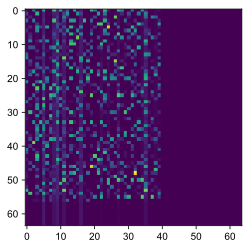

In [4]:
g = dpe.read(0, method='fast')
plt.imshow(g)

In [5]:
load_workspace(vars(), 'data/demo')

c:\users\lcan\virtualenvs\py37\lib\site-packages\dill\_dill.py:472: UserWarning: This figure was saved with matplotlib version 3.1.1 and is unlikely to function correctly.
  obj = StockUnpickler.load(self)


Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, mat_contents, finalGconv, img_idx, image, vectors, ts, output, soft_output, lin_cor_conv, c, output_cor, x, y, x1, g, outputs, software, g1, g2, linear_factors_conv, xs, acc, result, finalGfc, x2, sc1, sc2, Gfc1, Gfc2, output1, software1, output2, software2, new_lin_cor_fc1, new_lin_cor_fc2, output_corr, ys, batch_size, i, idx1, idx2, NO, FALSE, OFF, YES, TRUE, ON, N, S, W, E, NW, SW, NE, SE, NS, EW, NSEW, CENTER, NONE, X, Y, BOTH, LEFT, TOP, RIGHT, BOTTOM, RAISED, SUNKEN, FLAT, RIDGE, GROOVE, SOLID, HORIZONTAL, VERTICAL, NUMERIC, CHAR, WORD, BASELINE, INSIDE, OUTSIDE, SEL, SEL_FIRST, SEL_LAST, END, INSERT, CURRENT, ANCHOR, ALL, NORMAL, DISABLED, ACTIVE, HIDDEN, CASCADE, CHECKBUTTON, COMMAND, RADIOBUTTON, SEPARATOR, SINGLE, BROWSE, MULTIPLE, EXTENDED, DOTBOX, UNDERLINE, PIESLICE, CHORD, ARC, FIRST, LAST, BUTT, PROJECTING, ROUND, BEVEL, MITER, MOVETO, SCROLL, UNITS, PAGES, wantobjects, TkVersion, TclVersion,

In [6]:
nn = NN_dpe(weights)
# dpe.N_BIT = 8

In [7]:
import time

img_idx = 1

image = test_images[img_idx]
vectors = nn._conv_flattern(image)

# normalize
vectors /= np.abs(vectors).max()

ts = time.time()
output = dpe.multiply(1, vectors, c_sel=[0, 14], r_start=0, mode=0, Tdly=500 ) / (nn.Gratio/2)
print(time.time()-ts)
soft_output = (finalGconv.T @ vectors).T / (nn.Gratio/2)

3.300413131713867


In [8]:
lin_cor_conv = []
for c in range(14):
    lin_cor_conv.append( np.polyfit(output[:,c], soft_output[:,c], 1))

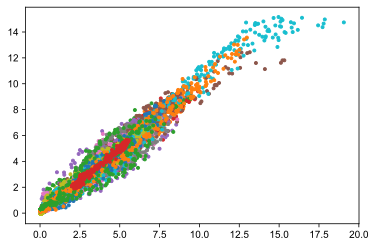

In [9]:
output_cor = dpe.lin_corr(output, lin_cor_conv)

for c in range(14):
    x = soft_output[:,c]
    y = output_cor[:,c]
    
    plt.plot(x,y,'.')
    
x = output_cor[:,::2] - output_cor[:,1::2]

x = x.reshape(20,20,-1)

In [10]:
acc = []
i = 0

xs = []

for label, img in zip(test_labels, test_images):
    
    vectors = nn._conv_flattern(img)
    
    # Convolution hardware call
#     output = dpe.multiply(0, vectors, c_sel=[20, 34], r_start=20, mode=0, Tdly=500) / (nn.Gratio/2)
    output = dpe.multiply(1, vectors, c_sel=[0, 14], r_start=0, mode=0, Tdly=500 ) / (nn.Gratio/2)
    output_cor = dpe.lin_corr(output, lin_cor_conv)
    x = output_cor[:,::2] - output_cor[:,1::2]

    x = x.reshape(20,20,-1)
    
    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    
    # Software fully connect
    xs.append(x1)
    y = nn.dense(x1)
    
    acc.append( y.argmax() == label)
    
    display.clear_output(wait=True)
    
    # Plot
#     fig = plt.figure(1)
#     for ii in range(7):
#         plt.subplot('33' + str(ii+1))
#         plt.title('Channel #' + str(ii))
#         plt.imshow(x[:,:,ii])
# #         plt.colorbar()
#     plt.tight_layout()
#     display.display(fig)
    
    print(f'idx={i}, predicted: {y.argmax()}, label: {test_labels[i]}')
    acc.append( y.argmax() == test_labels[i] )
    print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')
    
    i += 1

idx=357, predicted: 1, label: 1
	 Accuracy = 86.59%


KeyboardInterrupt: 

In [11]:
xs = np.array(xs)
np.shape(xs)


(358, 112)

In [13]:
xs = np.concatenate((xs, np.ones((xs.shape[0], 1))), axis=1)

In [16]:
x = xs[-350:]

x1 = x[:,:57].T
x2 = x[:,57:].T

sc1 = x1.max()
sc2 = x2.max()

Gfc1 = finalGfc[:57]
Gfc2 = finalGfc[57:]

x1 = x1 / sc1
x2 = x2 / sc2

dpe.N_BIT = 8

output1 = dpe.multiply(0, x1, c_sel=[0, 20], mode=0, Tdly=500)
software1 = (Gfc1.T @ x1).T 

output2 = dpe.multiply(0, x2, c_sel=[20, 40], mode=0, Tdly=500)
software2 = (Gfc2.T @ x2).T

In [17]:
new_lin_cor_fc1 = []
new_lin_cor_fc2 = []
for c in range(20):
    new_lin_cor_fc1.append( np.polyfit(output1[:,c], software1[:,c], 1))
    new_lin_cor_fc2.append( np.polyfit(output2[:,c], software2[:,c], 1))

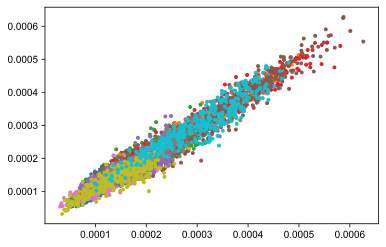

In [18]:
output_corr = dpe.lin_corr(output2, new_lin_cor_fc2)
software = (Gfc2.T @ x2).T 

for c in range(20):
    x = software[:,c]
    y = output_corr[:,c]
    
#     plt.figure(c)
    plt.plot(x,y,'.')

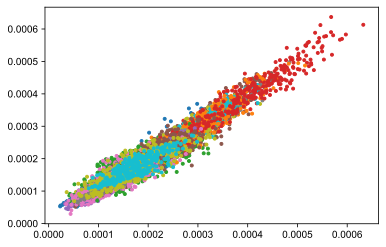

In [19]:
output_corr = dpe.lin_corr(output1, new_lin_cor_fc1)
software = (Gfc1.T @ x1).T 

for c in range(20):
    x = software[:,c]
    y = output_corr[:,c]
    
#     plt.figure(c)
    plt.plot(x,y,'.')

In [20]:
save_workspace({'xs': xs, 
                'new_lin_cor_fc1': new_lin_cor_fc1, 
                'new_lin_cor_fc2': new_lin_cor_fc2, 
                'lin_cor_conv': lin_cor_conv, 
                'finalGfc': finalGfc,
                'finalGconv': finalGconv,
               'weights': weights,
               'r_conv': 0,
                'c_conv': 0,
                'arr_conv': 1,
                'r_fc': 0,
                'c_fc': 0,
                'arr_fc': 0,
               }, 
               note='mnist_config_prober1')

Saving xs(<class 'numpy.ndarray'>), new_lin_cor_fc1(<class 'list'>), new_lin_cor_fc2(<class 'list'>), lin_cor_conv(<class 'list'>), finalGfc(<class 'numpy.ndarray'>), finalGconv(<class 'numpy.ndarray'>), weights(<class 'numpy.ndarray'>), r_conv(<class 'int'>), c_conv(<class 'int'>), arr_conv(<class 'int'>), r_fc(<class 'int'>), c_fc(<class 'int'>), arr_fc(<class 'int'>), to 20200206-122734-mnist_config_prober1.pkl
Saving xs(<class 'numpy.ndarray'>), new_lin_cor_fc1(<class 'list'>), new_lin_cor_fc2(<class 'list'>), lin_cor_conv(<class 'list'>), finalGfc(<class 'numpy.ndarray'>), finalGconv(<class 'numpy.ndarray'>), weights(<class 'numpy.ndarray'>), r_conv(<class 'int'>), c_conv(<class 'int'>), arr_conv(<class 'int'>), r_fc(<class 'int'>), c_fc(<class 'int'>), arr_fc(<class 'int'>), to 20200206-122734-mnist_config_prober1.mat


In [33]:
ys = []
batch_size = 150

for i in range( (len(test_images)-1)//batch_size + 1 ):
    idx1 = i * batch_size
    idx2 = (i+1) * batch_size
    idx2 = idx2 if idx2<= len(test_images) else len(test_images)
    
    print(f'Running on sample {idx1}-{idx2}')

    x = xs[idx1:idx2]

    x1 = x[:,:57].T
    x2 = x[:,57:].T

    sc1 = x1.max()
    sc2 = x2.max()

#     Gfc1 = nn.Gfc[:57]
#     Gfc2 = nn.Gfc[57:]

    x1 = x1 / sc1
    x2 = x2 / sc2
    
    output1  = dpe.multiply(0, x1, c_sel=[0, 20], mode=0, Tdly=500)
    output1 = dpe.lin_corr(output1, new_lin_cor_fc1) * sc1

    output2  = dpe.multiply(0, x2, c_sel=[20, 40], mode=0, Tdly=500)
    output2 = dpe.lin_corr(output2, new_lin_cor_fc2) * sc2

    outputs = output1 + output2
    
    y = outputs[:,::2] - outputs[:,1::2]
    
    display.clear_output(wait=True)
    
    print(f'Accuracy = {np.mean(y.argmax(axis=1) == test_labels[idx1:idx2])*100:.2f}%')
    ys.append(y)
    print(f'Total accuracy = {np.mean(np.concatenate(ys).argmax(axis=1) == test_labels[:idx2])*100:.2f}%')
    
ys = np.concatenate(ys)  

Accuracy = 0.00%
Total accuracy = 0.00%
Running on sample 300-450


c:\users\localuser\~\.venvs\py37\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
c:\users\localuser\~\.venvs\py37\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


ValueError: zero-size array to reduction operation maximum which has no identity